# TFLITE generation for unity application

In [2]:
import os
import time
import tempfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from tensorflow.python.platform import gfile
from keras.datasets import cifar10
from keras.optimizers import SGD,Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

-----------

## Current Project summary

* current model is coco_ssd_mobilenet
* (https://github.com/asus4/tf-lite-unity-sample)
* It follows object detection supported from tensorflow
* (https://www.tensorflow.org/lite/models/object_detection/overview)

-------

## Training dataset load

* Here, we are going to use CIFAR-10 dataset for simple testing

In [20]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [21]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [22]:
# Normalizing
# x_train=x_train / 255.0
# x_test=x_test / 255.0

# x_train=x_train.astype(np.float32) / 255.0
# x_test=x_test.astype(np.float32) / 255.0

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

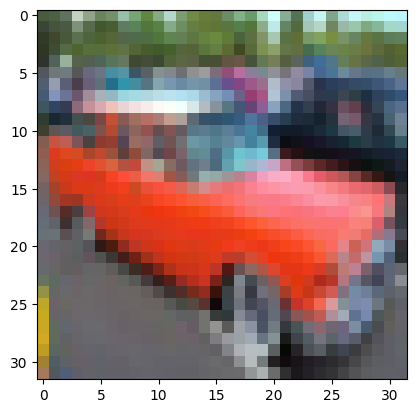

In [23]:
img = plt.imshow(x_train[1])

---------------

## Prepare the detection model

In [17]:
## importing original MobileNetV2 model
from keras.applications.mobilenet_v2 import MobileNetV2

In [24]:
## Reorganizing the MobileNetV2 model for our own custom dataset
## and be ready for the transfer learning
base_model = MobileNetV2(include_top = False,
                    weights= 'imagenet',
                    input_shape=(32,32,3),
                    classes = y_train.shape[1])

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[

In [27]:
#Adding layers to base model of MobileNet

model = Sequential()

#Creating base layer of VGG19
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

#Adding the Dense Layers and Dropout
model.add(Dense(512,activation=('relu'))) 

model.add(Dense(256,activation=('relu'))) 

model.add(Dropout(.3))

model.add(Dense(128,activation=('relu')))

model.add(Dropout(.2))

model.add(Dense(10,activation=('softmax')))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1, 1, 1280)        2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1, 1, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [29]:
#Compiling Model using SGD 

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#Training Model
hist = model.fit(x_train, y_train_cat, batch_size = 100, epochs = 20, validation_split = 0.1)

Epoch 1/20
315/315 [==============================] - 52s 140ms/step - loss: 1.7543 - accuracy: 0.3736 - val_loss: 4.2739 - val_accuracy: 0.1154
Epoch 2/20
315/315 [==============================] - 45s 143ms/step - loss: 1.0907 - accuracy: 0.6422 - val_loss: 2.9548 - val_accuracy: 0.1840
Epoch 3/20
315/315 [==============================] - 44s 139ms/step - loss: 0.8744 - accuracy: 0.7204 - val_loss: 2.5869 - val_accuracy: 0.3757
Epoch 4/20
315/315 [==============================] - 44s 141ms/step - loss: 0.7701 - accuracy: 0.7575 - val_loss: 2.8961 - val_accuracy: 0.3914
Epoch 5/20
315/315 [==============================] - 44s 140ms/step - loss: 0.6940 - accuracy: 0.7846 - val_loss: 1.7769 - val_accuracy: 0.5100
Epoch 6/20
315/315 [==============================] - 44s 140ms/step - loss: 0.6302 - accuracy: 0.8026 - val_loss: 1.6155 - val_accuracy: 0.3751
Epoch 7/20
315/315 [==============================] - 44s 140ms/step - loss: 0.5924 - accuracy: 0.8159 - val_loss: 1.7736 - val_ac

-----------

## Saving the model

In [ ]:
## check the current model path (where pb file saved)
model_path = 'C:/Users/user/Jupyter/ssd_temp/'
model.save('C:/Users/user/Jupyter/ssd_temp/retrained_model')

----------

## Converting the pb model into tflite file

In [ ]:
## load pb model
pb_model = tf.saved_model.load(model_path)

* Setting the converter

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
        yield [input_value]

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_path) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.representative_dataset = representative_data_gen
# # Ensure that if any ops can't be quantized, the converter throws an error
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

* Convert the saved pb model into tflite format

In [ ]:
tflite_model = converter.convert()

* Save the tflite model into the path

In [ ]:
open('E:/ssd_model_temp/ssd_model.tflite', "wb").write(tflite_model)